In [232]:
import numpy as np
from src.fistanet.loader import DataSplit
import torch
import os
import matplotlib.pyplot as plt
# from src.steinbrinker.BPDN import BPDN
import timeit

In [64]:
DATA_DIR = './data'
DATA_FILE_GEN = 'generated/BW_master_10000_2024-04-07-12-43-32.pkl'
DATA_FILE_SIGS = 'steinbrinker/testing_data_mvg_avg.npy'
DATA_FILE_BW = 'mit-bih/bw'
DATA_FILE_GAUSS = 'generated/gaussian_noise.npy'
DATA_FILE_BPDN_1 = 'generated/BW_alphas-BPDN-1iters_10000_2024-04-07-12-43-32.npy'
DATA_FILE_BPDN_3 = 'generated/BW_alphas-BPDN-3iters_10000_2024-04-07-12-43-32.npy'
DATA_FILE_BPDN_5 = 'generated/BW_alphas-BPDN-5iters_10000_2024-04-07-12-43-32.npy'
DATA_FILE_BPDN_FINAL = 'generated/BW_alphas-BPDN_10000_2024-04-07-12-43-32.npy'
DICT_FILE_BW = 'steinbrinker/dictionary_BW_real_data.npy'
NOISE_TYPE = 'bw'
if NOISE_TYPE == 'bw':
    DATA_FILE_NOISE = DATA_FILE_BW
elif NOISE_TYPE == 'gauss':
    DATA_FILE_NOISE = DATA_FILE_GAUSS
DATA_SIZE = 10000
BATCH_SIZE = 1000
TVT_SPLIT = {
    'train': 80,
    'valid': 10,
    'test': 10
}

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dictionary = np.load(os.path.join(DATA_DIR, DICT_FILE_BW))
dictionary = torch.from_numpy(dictionary)
dictionary = dictionary.clone().detach().to(device=device)
dictionary = dictionary.repeat((next(iter(tst_ldr))[0].shape[0], 1, 1))

In [66]:
run_path = '2024-05-28-22-47-56_high-discrepancy_all-zeros-init'
x_fistanet = np.load(os.path.join('D:/USERS/galiger.gergo/ecg-denoising/runs', run_path, 'infered', 'BW_alphas-FISTA-Net_10000_test.npy'))
x_fistanet = torch.Tensor(x_fistanet).clone().detach().to(device=device).double()

In [188]:
def plot_bar_comp(meas_list, y_label, title):
    x = np.arange(len(meas_list.keys()))
    width = 0.5

    fig, ax = plt.subplots(layout='constrained')

    for i, (attribute, measurement) in enumerate(meas_list.items()):
        rects = ax.bar(x[i]+width, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)

    ax.set_xticks(x + width, meas_list.keys())
    ax.set_ylabel(y_label)
    ax.set_title(title)

    plt.show()

In [170]:
def plot_comp_example(i):
    global x_in, y_target, denoised_fistanet, denoised_bpdn, denoised_bpdn1, denoised_bpdn3, denoised_bpdn5
    plt.plot(x_in[i, :].cpu(), label='noisy input', linewidth=0.5)
    plt.plot(y_target[i, :].cpu(), label='target', linewidth=0.5)
    plt.plot(denoised_fistanet[i, :].cpu(), label='FISTA-Net', linewidth=0.5)
    plt.plot(denoised_bpdn[i, :].cpu(), label='BPDN max iter', linewidth=0.5)
    plt.plot(denoised_bpdn5[i, :].cpu(), label='BPDN 5 iter', linewidth=0.5)
    plt.plot(denoised_bpdn3[i, :].cpu(), label='BPDN 3 iter', linewidth=0.5)
    plt.plot(denoised_bpdn1[i, :].cpu(), label='BPDN 1 iter', linewidth=0.5)
    plt.legend()

In [214]:
def plot_comp_example_alpha(i, filt_list=[True, True, True, True, True], ylim=None):
    global x_fistanet, x_bpdn, x_bpdn1, x_bpdn3, x_bpdn5
    plt.plot([0], linewidth=0.5)
    plt.plot([0], linewidth=0.5)
    if filt_list[0]:
        plt.plot(x_fistanet[i, :].cpu(), label='FISTA-Net', linewidth=0.5)
    if filt_list[1]:
        plt.plot(x_bpdn[i, :].cpu(), label='BPDN max iter', linewidth=0.5)
    if filt_list[2]:
        plt.plot(x_bpdn5[i, :].cpu(), label='BPDN 5 iter', linewidth=0.5)
    if filt_list[3]:
        plt.plot(x_bpdn3[i, :].cpu(), label='BPDN 3 iter', linewidth=0.5)
    if filt_list[4]:
        plt.plot(x_bpdn1[i, :].cpu(), label='BPDN 1 iter', linewidth=0.5)
    if ylim != None:
        plt.ylim(ylim)
    plt.legend()

## Compare average MSE on testing dataste (1000 samples)

In [67]:
trn_ldr, val_ldr, tst_ldr = DataSplit(DATA_DIR, NOISE_TYPE, DATA_FILE_GEN, DATA_FILE_SIGS, DATA_FILE_NOISE, DATA_FILE_BPDN_1,
                                      DATA_FILE_BPDN_FINAL, TVT_SPLIT, BATCH_SIZE)
x_in, y_target, x_bpdn1, x_bpdn = next(iter(tst_ldr))
trn_ldr, val_ldr, tst_ldr = DataSplit(DATA_DIR, NOISE_TYPE, DATA_FILE_GEN, DATA_FILE_SIGS, DATA_FILE_NOISE, DATA_FILE_BPDN_3,
                                      DATA_FILE_BPDN_FINAL, TVT_SPLIT, BATCH_SIZE)
x_in, y_target, x_bpdn3, x_bpdn = next(iter(tst_ldr))
trn_ldr, val_ldr, tst_ldr = DataSplit(DATA_DIR, NOISE_TYPE, DATA_FILE_GEN, DATA_FILE_SIGS, DATA_FILE_NOISE, DATA_FILE_BPDN_5,
                                      DATA_FILE_BPDN_FINAL, TVT_SPLIT, BATCH_SIZE)
x_in, y_target, x_bpdn5, x_bpdn = next(iter(tst_ldr))

x_bpdn1 = x_bpdn1.clone().detach().to(device=device)
x_bpdn3 = x_bpdn3.clone().detach().to(device=device)
x_bpdn5 = x_bpdn5.clone().detach().to(device=device)
x_in = x_in.clone().detach().to(device=device)
x_bpdn = x_bpdn.clone().detach().to(device=device)
y_target = y_target.clone().detach().to(device=device)

denoised_bpdn1 = x_in - torch.bmm(dictionary, x_bpdn1.unsqueeze(2)).squeeze()
denoised_bpdn3 = x_in - torch.bmm(dictionary, x_bpdn3.unsqueeze(2)).squeeze()
denoised_bpdn5 = x_in - torch.bmm(dictionary, x_bpdn5.unsqueeze(2)).squeeze()
denoised_bpdn = x_in - torch.bmm(dictionary, x_bpdn.unsqueeze(2)).squeeze()
denoised_fistanet = x_in - torch.bmm(dictionary, x_fistanet.unsqueeze(2)).squeeze()

In [166]:
loss = torch.nn.MSELoss()
losses_MSE = {
    'fistanet': loss(y_target, denoised_fistanet).item(),
    'bpdn_maxiter': loss(y_target, denoised_bpdn).item(),
    'bpdn_5iter': loss(y_target, denoised_bpdn5).item(),
    'bpdn_3iter': loss(y_target, denoised_bpdn3).item(),
    'bpdn_1iter': loss(y_target, denoised_bpdn1).item(),
}

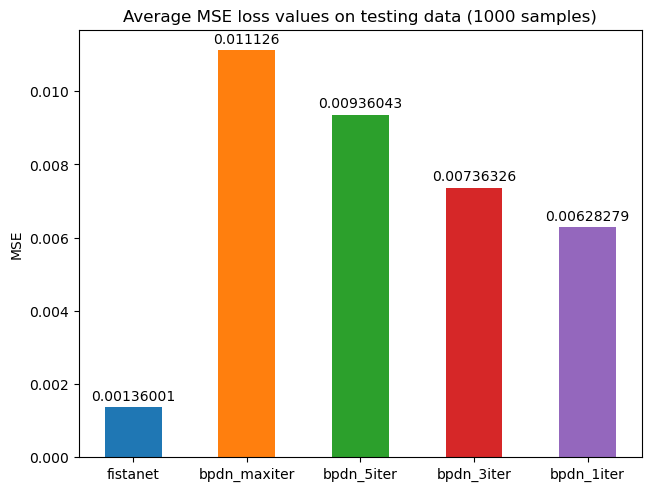

In [189]:
plot_bar_comp(losses_MSE, 'MSE', 'Average MSE loss values on testing data (1000 samples)')

## Compare single BW denoising examples

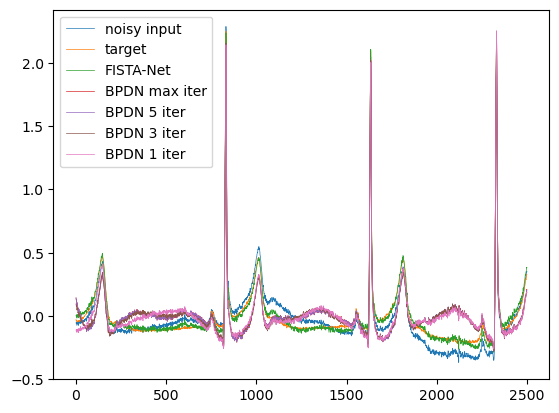

In [171]:
plot_comp_example(20)

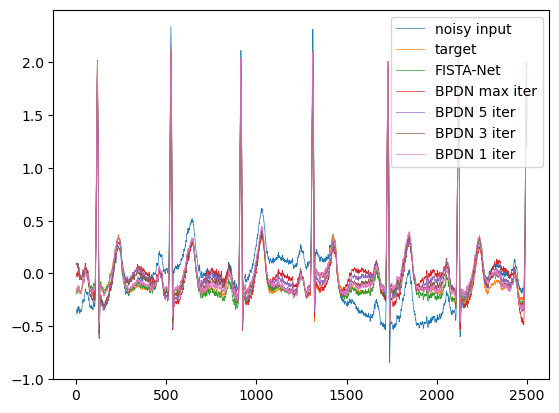

In [176]:
plot_comp_example(210)

## Compare sparcity - percentage of non-zero elements

In [218]:
non_zero_perc_func = lambda x: torch.sum(x.cpu().squeeze().detach()>1e-6).item() / (x.shape[0] * x.shape[1]) * 100
non_zero_perc = {
    'fistanet': non_zero_perc_func(x_fistanet),
    'bpdn_maxiter': non_zero_perc_func(x_bpdn),
    'bpdn_5iter': non_zero_perc_func(x_bpdn1),
    'bpdn_3iter': non_zero_perc_func(x_bpdn3),
    'bpdn_1iter': non_zero_perc_func(x_bpdn5),
}

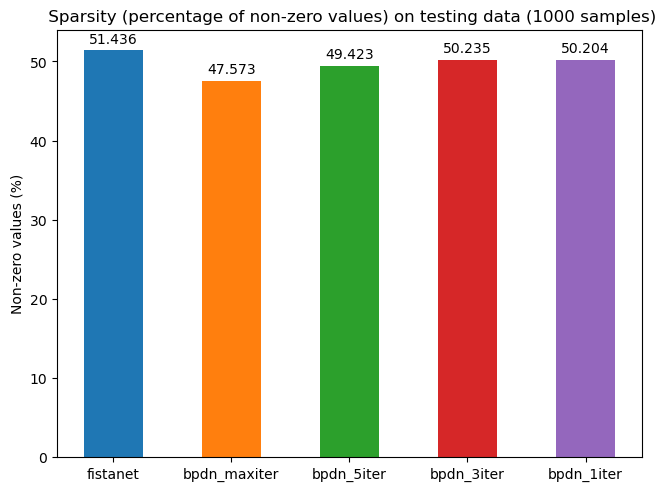

In [219]:
plot_bar_comp(non_zero_perc, 'Non-zero values (%)', ' Sparsity (percentage of non-zero values) on testing data (1000 samples)')

In [228]:
non_zero_perc_func = lambda x: torch.sum(x.cpu().squeeze().detach()>1e-3).item() / (x.shape[0] * x.shape[1]) * 100
non_zero_perc = {
    'fistanet': non_zero_perc_func(x_fistanet),
    'bpdn_maxiter': non_zero_perc_func(x_bpdn),
    'bpdn_5iter': non_zero_perc_func(x_bpdn1),
    'bpdn_3iter': non_zero_perc_func(x_bpdn3),
    'bpdn_1iter': non_zero_perc_func(x_bpdn5),
}

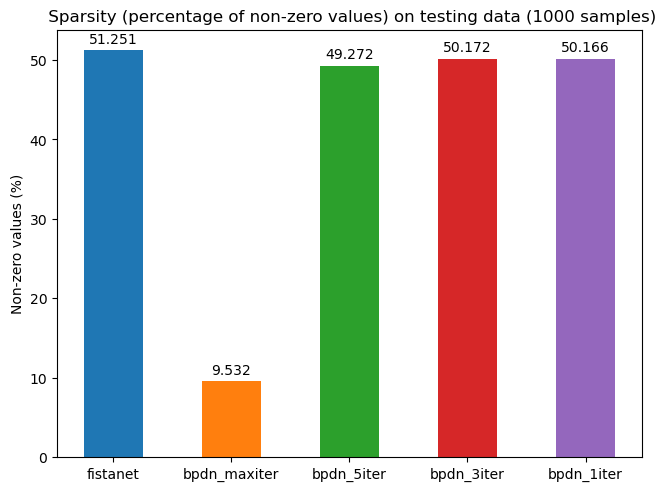

In [229]:
plot_bar_comp(non_zero_perc, 'Non-zero values (%)', ' Sparsity (percentage of non-zero values) on testing data (1000 samples)')

In [230]:
non_zero_perc_func = lambda x: torch.sum(x.cpu().squeeze().detach()>1e-1).item() / (x.shape[0] * x.shape[1]) * 100
non_zero_perc = {
    'fistanet': non_zero_perc_func(x_fistanet),
    'bpdn_maxiter': non_zero_perc_func(x_bpdn),
    'bpdn_5iter': non_zero_perc_func(x_bpdn1),
    'bpdn_3iter': non_zero_perc_func(x_bpdn3),
    'bpdn_1iter': non_zero_perc_func(x_bpdn5),
}

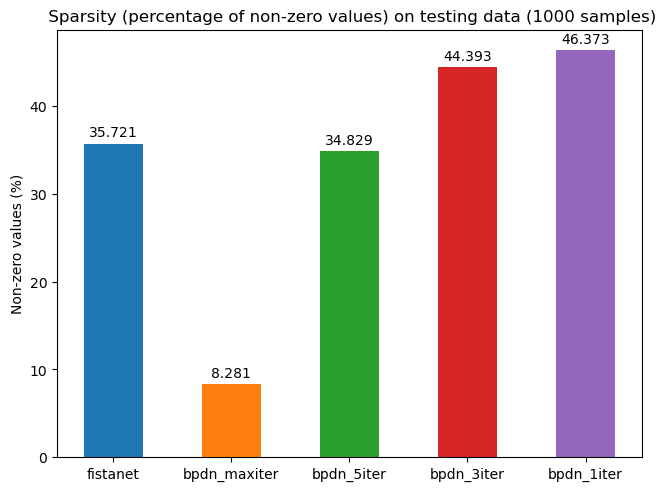

In [231]:
plot_bar_comp(non_zero_perc, 'Non-zero values (%)', ' Sparsity (percentage of non-zero values) on testing data (1000 samples)')

## Compare single BW noise approximation examples

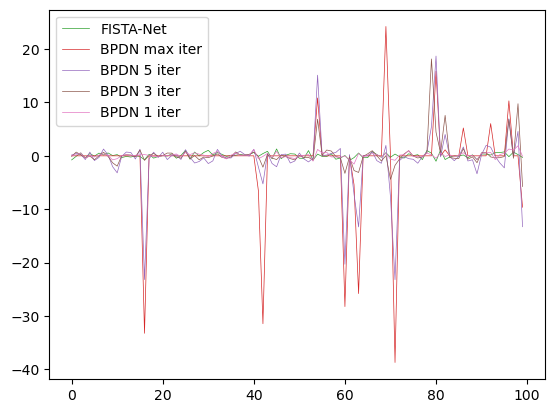

In [199]:
plot_comp_example_alpha(0)

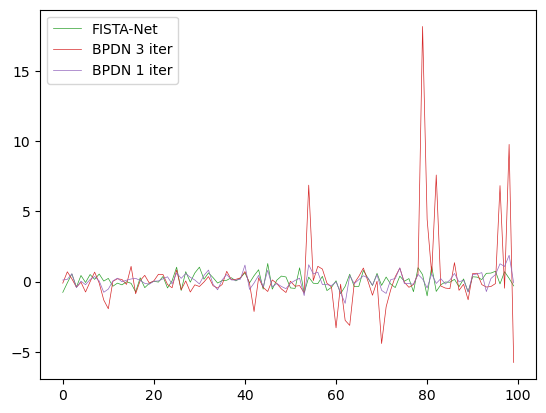

In [202]:
plot_comp_example_alpha(0, [True, False, False, True, True])

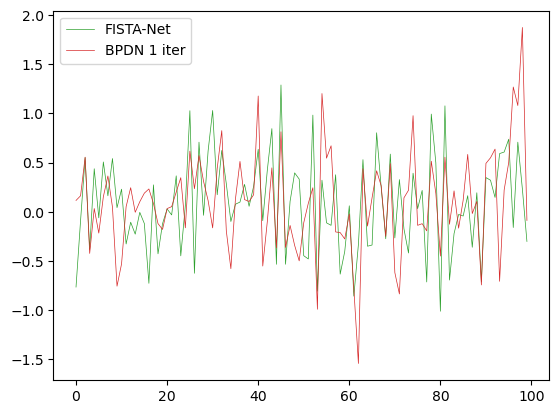

In [203]:
plot_comp_example_alpha(0, [True, False, False, False, True])

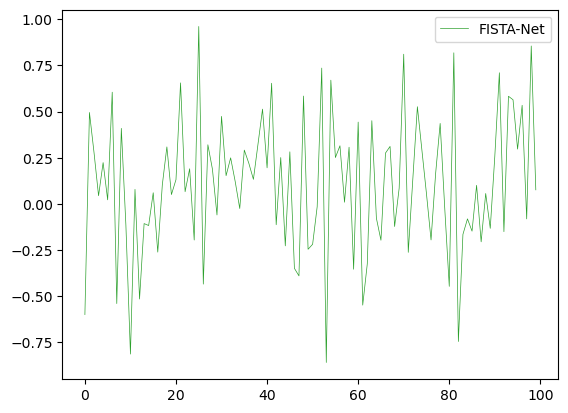

In [209]:
plot_comp_example_alpha(210, [True, False, False, False, False])

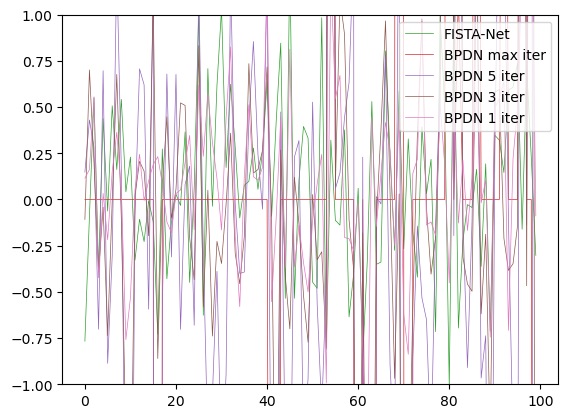

In [215]:
plot_comp_example_alpha(0, ylim=(-1, 1))

## Compare inference times

In [239]:
x_fistanet = np.load(os.path.join('D:/USERS/galiger.gergo/ecg-denoising/runs', run_path, 'infered', 'BW_alphas-FISTA-Net_10000_test.npy'))

start = timeit.default_timer()

x_fistanet = torch.Tensor(x_fistanet).clone().detach().to(device=device).double()

stop = timeit.default_timer()

print('FISTA-Net GPU (1 batch = 1000 samples):', stop - start, 's') 

FISTA-Net GPU (1 batch = 1000 samples): 0.0009037999989232048 s
